In [21]:
import gpjax as gpx
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt
import seaborn as sns 
import jax
import optax as ox
import distrax as dx 
key = jr.PRNGKey(123)

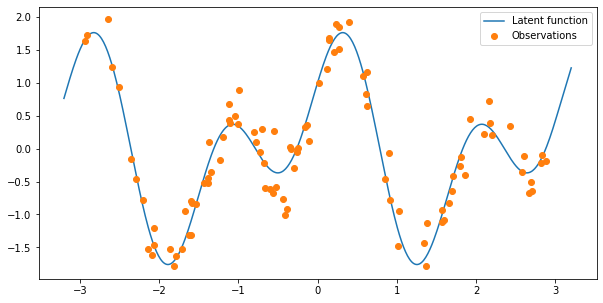

In [2]:
n = 100
noise = 0.3

x = jr.uniform(key=key, minval=-3.0, maxval=3.0, shape=(n,)).sort().reshape(-1, 1)
f = lambda x: jnp.sin(4 * x) + jnp.cos(2 * x)
signal = f(x)
y = signal + jr.normal(key, shape=signal.shape) * noise

D = gpx.Dataset(X=x, y=y)

xtest = jnp.linspace(-3.2, 3.2, 500).reshape(-1, 1)
ytest = f(xtest)


fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(xtest, ytest, label="Latent function")
ax.plot(x, y, "o", label="Observations")
ax.legend(loc="best")


In [3]:
def unique_legend(ax):
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys(), loc ='best')
    return ax

In [4]:
kernel = gpx.RBF()
prior = gpx.Prior(kernel=kernel)

params, trainable, constrainer, unconstrainer = gpx.initialise(prior)
prior_dist = prior(params)(xtest)

prior_mean = prior_dist.mean()
prior_std = jnp.sqrt(prior_dist.covariance().diagonal())
samples = prior_dist.sample(seed=key,sample_shape=20).T

likelihood = gpx.Gaussian(num_datapoints=n)
posterior = prior * likelihood
params, trainable, constrainer, unconstrainer = gpx.initialise(posterior)
params = gpx.transform(params, unconstrainer)
mll = jax.jit(posterior.marginal_log_likelihood(D, constrainer, negative=True))
opt = ox.adam(learning_rate=0.01)
final_params = gpx.fit(
    mll,
    params,
    trainable,
    opt,
    n_iters=500,
)
final_params = gpx.transform(final_params, constrainer)
latent_dist = posterior(D, final_params)(xtest)
predictive_dist = likelihood(latent_dist, final_params)

predictive_mean = predictive_dist.mean()
predictive_std = predictive_dist.stddev()

  0%|          | 0/500 [00:00<?, ?it/s]

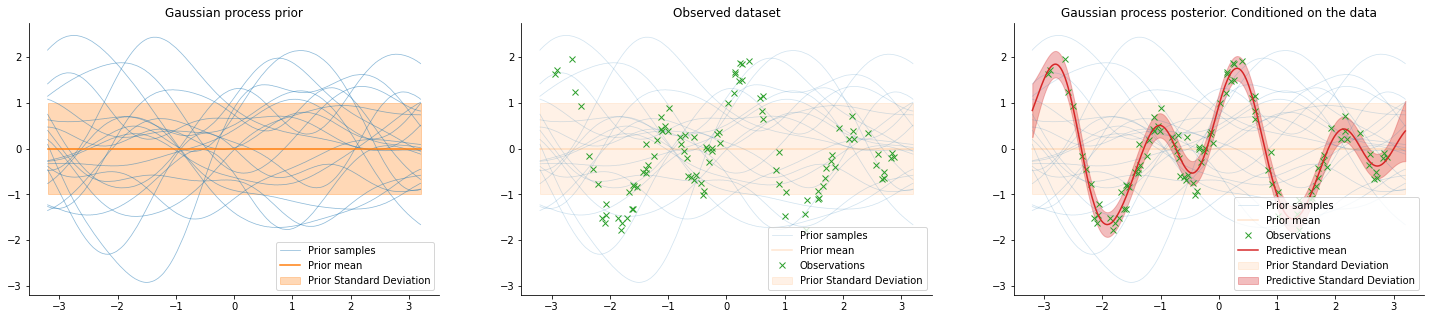

In [5]:


fig, (ax0, ax1, ax2) = plt.subplots(figsize=(25, 5), ncols=3)


ax0.plot(xtest, samples, color='tab:blue', alpha=0.5, label='Prior samples', linewidth=0.75)
ax0.plot(xtest, prior_mean, color='tab:orange', label='Prior mean', linewidth=1.5)
ax0.fill_between(xtest.flatten(), prior_mean - prior_std, prior_mean + prior_std, color='tab:orange', alpha=0.3, label='Prior Standard Deviation')
ax0 = unique_legend(ax0)
ax0.set_title('Gaussian process prior')

ax1.plot(xtest, samples, color='tab:blue', alpha=0.2, label='Prior samples', linewidth=0.75)
ax1.plot(xtest, prior_mean, color='tab:orange', label='Prior mean', linewidth=1.5, alpha=0.2)
ax1.fill_between(xtest.flatten(), prior_mean - prior_std, prior_mean + prior_std, color='tab:orange', alpha=0.1, label='Prior Standard Deviation')
ax1.plot(x, y, 'x', color='tab:green', label='Observations')
ax1 = unique_legend(ax1)
ax1.set_title('Observed dataset')


ax2.plot(xtest, samples, color='tab:blue', alpha=0.2, label='Prior samples', linewidth=0.75)
ax2.plot(xtest, prior_mean, color='tab:orange', label='Prior mean', linewidth=1.5, alpha=0.2)
ax2.fill_between(xtest.flatten(), prior_mean - prior_std, prior_mean + prior_std, color='tab:orange', alpha=0.1, label='Prior Standard Deviation')
ax2.plot(x, y, 'x', color='tab:green', label='Observations')
ax2.plot(xtest, predictive_mean, color='tab:red', label='Predictive mean', linewidth=1.5)
ax2.fill_between(xtest.flatten(), predictive_mean - predictive_std, predictive_mean + predictive_std, color='tab:red', alpha=0.3, label='Predictive Standard Deviation')
ax2 = unique_legend(ax2)
ax2.set_title('Gaussian process posterior. Conditioned on the data')



sns.despine()
plt.show()

/home/pindert2/miniconda3/envs/bayesian_ensembles/lib/python3.8/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


[]

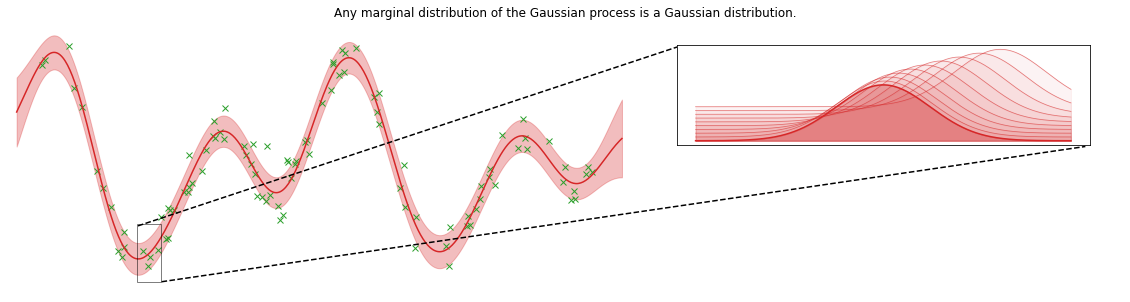

In [142]:

fig, ax = plt.subplots(figsize=(20, 5))

idx=100

ax.plot(x, y, 'x', color='tab:green', label='Observations')
ax.plot(xtest, predictive_mean, color='tab:red', label='Predictive mean', linewidth=1.5)
ax.fill_between(xtest.flatten(), predictive_mean - predictive_std, predictive_mean + predictive_std, color='tab:red', alpha=0.3, label='Predictive Standard Deviation')
# ax = unique_legend(ax)
ax.set_title('Any marginal distribution of the Gaussian process is a Gaussian distribution.')

axins = ax.inset_axes([0.6, 0.55, 0.37, 0.37])
marginal_x = jnp.linspace(predictive_mean[idx] - 4* predictive_std[idx], predictive_mean[idx] + 4* predictive_std[idx], 500)
for i in range(10):
    marginal = dx.Normal(predictive_mean[idx+3*i], predictive_std[idx+i*3])
    marginal_probs = marginal.prob(marginal_x)
    if i == 0:
        axins.plot(marginal_x, marginal_probs, color='tab:red', label='Predictive mean', linewidth=1.5)
        axins.fill_between(marginal_x, 0, marginal_probs, color='tab:red', alpha=0.3, label='Predictive Standard Deviation')
    else:
        axins.plot(marginal_x, marginal_probs+i*0.1, color='tab:red', linewidth=0.75, alpha=0.6)
        axins.fill_between(marginal_x, 0, marginal_probs+i*0.1, color='tab:red', alpha=0.05)


x1, x2, y1, y2 = xtest[idx]-0.01, xtest[idx]+0.01, predictive_mean[idx]-0.4, predictive_mean[idx]+0.4
# axins.set_xlim(x1, x2)
# axins.set_ylim(y1, y2)
# ax.plot([0.7, 0.9], [0.2, 1.7], transform=ax.transAxes)
# ax.plot([0.7, 0.9], [0.3, 1.], transform=ax.transAxes)
ax.plot((xtest[idx], 3.8), (-1.1, 1.95), color="black", linestyle='--')
ax.plot((xtest[idx]+0.25, 8.1), (-2.05, 0.25), color="black", linestyle='--')
ax.set_xlim(-3.3, 8.5)

ax.indicate_inset(bounds=[x1, y1, 0.25, 1.], edgecolor="black")
ax.axis('off')
axins.set_xticks([])
# for minor ticks
axins.set_xticks([], minor=True)
axins.set_yticks([])
# for minor ticks
axins.set_yticks([], minor=True)

In [71]:
ax.get_xlim()

(-3.5200000000000005, 3.5200000000000005)